In [1]:
import json
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import HTML
%matplotlib inline
plt.style.use('ggplot')
# parse the ResultOrders into a table
with open('resultorders.json','r') as ordersjson:
    orders = json.load(ordersjson)
column_names = []
first_item = list(orders.keys())[0]
for v in orders[first_item]:
    if not v in 'fills':
        column_names.append(v)
column_names.append('cash')

table = []
for k, v in orders.items():
    selected_rows = []
    for column in v:
        if column == 'fills':
            total_cash = 0
            for fill in v['fills']:
                total_cash += fill['qty'] * fill['price'] * .01
        else:
            selected_rows.append(v[column])
    selected_rows.append(total_cash)
    table.append(selected_rows)

df = pd.DataFrame(table, columns=column_names)
df['ts'] = pd.to_datetime(df['ts'])

# Load the quotes dataframe
quotes = pd.read_json('ResultQuoteSocket.json')
quotes['quoteTime'] = pd.to_datetime(quotes['quoteTime'])
quotes['lastTrade'] = pd.to_datetime(quotes['lastTrade'])
last = quotes["last"].iloc[-1]
if last is None:
    last = 0

acc_trades = df
acc_trades.loc[acc_trades.direction == 'buy', 'cash'] *= -1
acc_trades.loc[acc_trades.direction == 'sell', 'totalFilled'] *= -1

In [2]:
acc_group = acc_trades.groupby('account').sum()
acc_group['NAV'] = acc_group['totalFilled'] * (last * .01) + acc_group['cash']

h = HTML(acc_group[['totalFilled','cash','NAV']].sort_values(by = 'NAV', ascending = False).to_html())
my_file = open('charts/NAV.html','w')
my_file.write(h.data)
my_file.close()


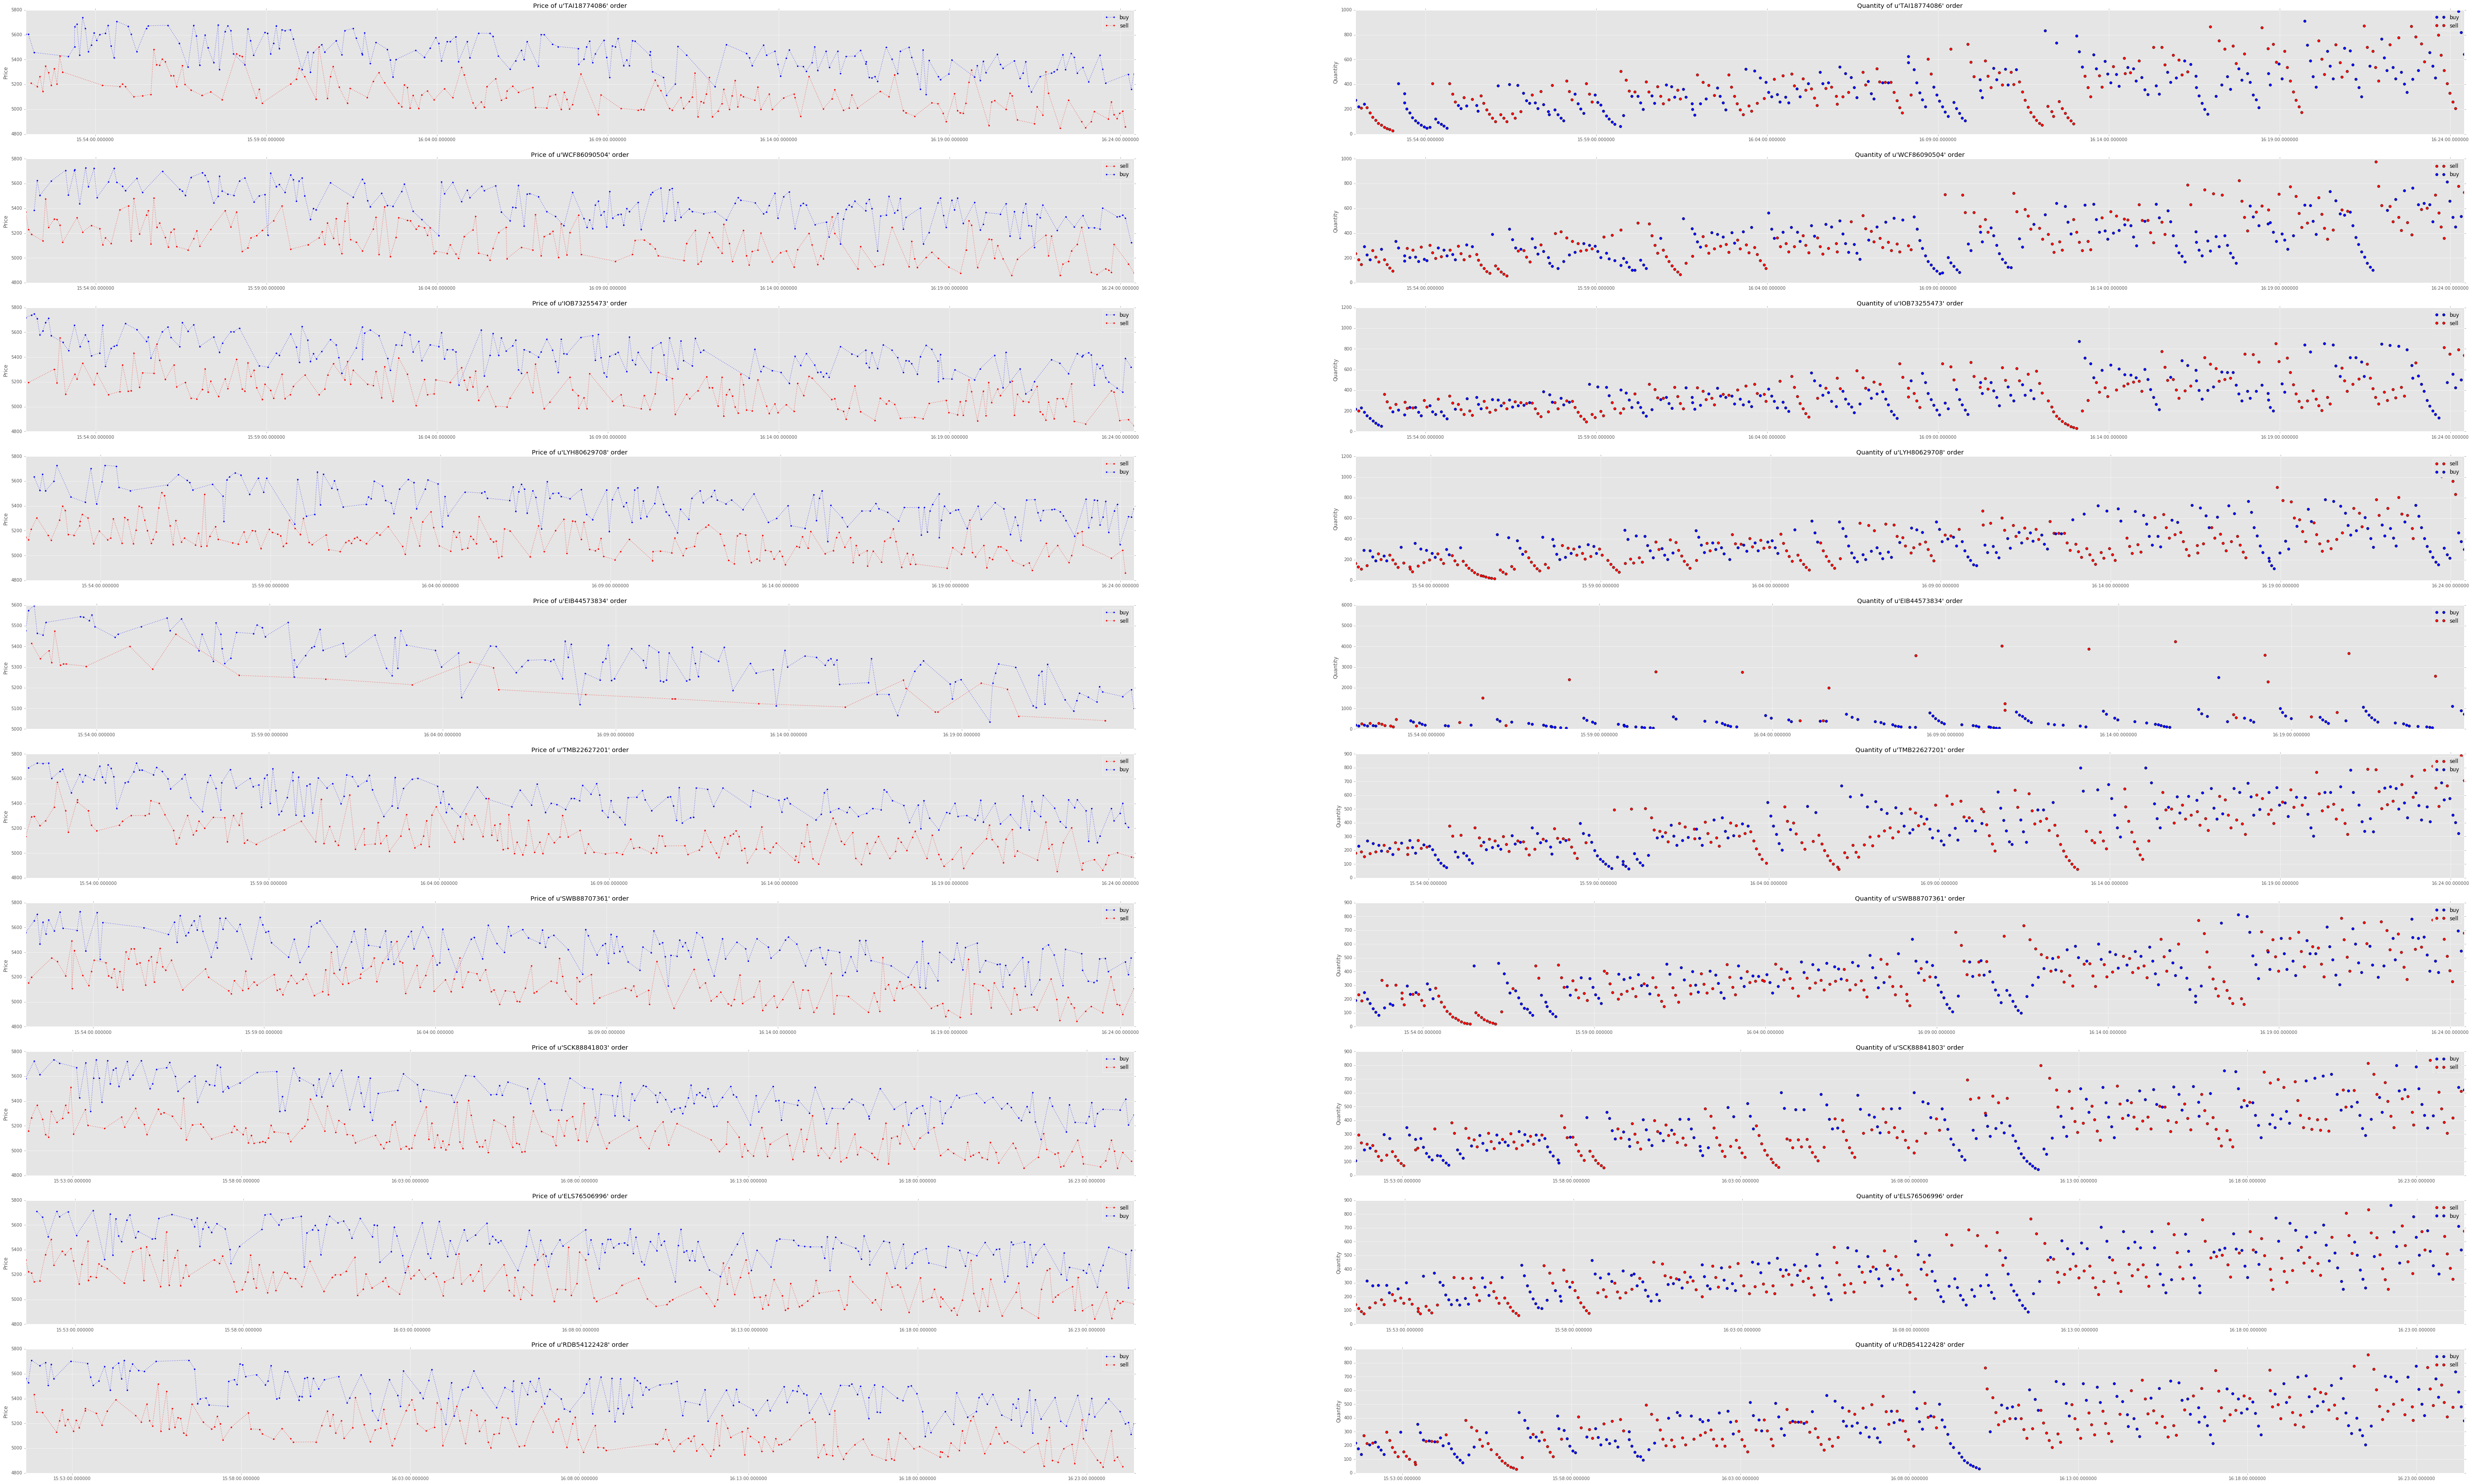

In [3]:

fig, ax = plt.subplots(10, 2, figsize=(100, 60))
plot_number = 0;
plt.title('Trade Price and Quantity over Time for accounts in venue %r' %(acc_trades['venue'][0]))      
for account in acc_group.sort_values(by = 'NAV', ascending = False).head(10).index:
        orders = acc_trades[acc_trades['account'] == account]
        orders = acc_trades[(acc_trades['account'] == account)].sort_values('ts', ascending = True)
        # fig, ax = plt.subplots(2, sharex = True, figsize=(15,8))
        ax[plot_number, 0].set_title("Price of %r order" % (account))
        ax[plot_number, 0].set_ylabel("Price")
        ax[plot_number, 1].set_title('Quantity of %r order' % (account))
        ax[plot_number, 1].set_ylabel("Quantity")
        colour = {'buy': 'blue', 'sell': 'red'}
        for direction in orders['direction'].unique():
            orderplt = orders[['ts','price','originalQty']][orders['direction'] == direction]
            ax[plot_number, 0].plot(orderplt['ts'],orderplt['price'],label=direction, 
                                    color = colour[direction],
                                    linestyle = ":",
                                    marker = ".")
            ax[plot_number, 1].plot(orderplt['ts'],orderplt['originalQty'], 'o', label=direction,  color = colour[direction])
        ax[plot_number, 0].legend()
        ax[plot_number, 1].legend()
        plot_number += 1  
plt.show()
fig.savefig('charts/Trade_Pattern_Of_Top10_NAV_Account_In_' + acc_trades['venue'][0] + '.png')

In [4]:
# combined = pd.merge(df, quotes, how = 'outer', left_on='ts', right_on = 'lastTrade')
# combined.dtypes
# combined.to_excel("combined.xlsx")